# Import Library

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sys
import gym
import matplotlib.pyplot as plt

# Plot Result
直接給大家看有做reward finetune和沒有做的效果差異
這裡step代表是完成一回合所花的步數，可以發現有做reward
fine tune去引導agent會得到比較好的結果。

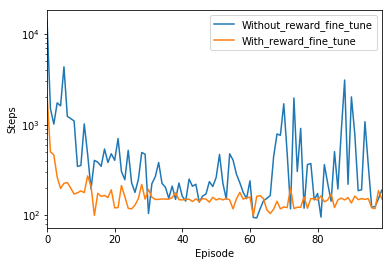

In [2]:
step_result = pd.concat([pd.read_csv('ref/Without_reward_fine_tune.csv'),
                         pd.read_csv('ref/With_reward_fine_tune.csv')],
                        axis = 1)
step_result.plot()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.yscale("log")
plt.show()

# 定義DeepQLearning
請大家將class中function的內容完成。投影片上應該也有答案～

In [2]:
class DeepQLearning:
    
    def __init__(
        self, 
        n_actions, 
        n_states, 
        gamma = 0.9, #遠見程度
        epsilon = 0.9,  #保守程度，越大就越容易用Q值大小來採取行動；越小則越容易產生隨機行動
        epsilon_increase = None,
        learning_rate = 0.001, #神經網路的更新率
        memory_size = 50, #####
        batch_size = 32, #####
        nueron_num = 10
    ):
    
        self.n_actions = n_actions
        self.n_states = n_states
        self.gamma = gamma
        self.epsilon_max = epsilon #####
        self.epsilon_increase = epsilon_increase #####
        self.epsilon = 0 if epsilon_increase is not None else epsilon #####
        self.lr = learning_rate
        self.memory_size = memory_size #####
        self.memory_counter = 0 #####
        self.batch_size = batch_size ####
        self.nueron_num = nueron_num
        ##### initialize memory
        self.memory = np.zeros((self.memory_size, n_states * 2 + 2))
        """
        memory用來記錄探索環境所蒐集到的資料用來更新神經網路，從公式Q_target = R(s,a) + max(Q(s_,a))*Gamma
        得知我們需要存取的資訊有s(current state), s_(next state), r(reward), a(action) 因此總共需要 2*n_states
        +2的dimension
        """
        
        tf.reset_default_graph() ## 重新 build graph 需要跑這行
        self.sess = tf.Session() #宣告session
        #輸入current state
        self.state_input = tf.placeholder(shape = [None, self.n_states], 
                                          name = 'input',
                                          dtype = tf.float32)
        #q_target = R(s, action) + Q(s_)*Gamma 
        self.q_target = tf.placeholder(shape = [None, self.n_actions], 
                                       name = 'q_target',
                                       dtype = tf.float32)
        #搭建神經網路
        with tf.variable_scope('Q_table'):
            self.q_eval = self.build_network(self.nueron_num, Trainable = True, scope = 'net_eval') 
            self.q_next = self.build_network(self.nueron_num, Trainable = False, scope = 'net_target') ##### 利用另外一個參數較舊的神經網路來給出下一步的q值並計算q_target
        
        #管理神經網路的parameters
        self.Qnet_eval_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Q_table/net_eval')
        self.Qnet_target_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Q_table/net_target') #####
        #更新舊神經網路的參數
        self.replace_net_params = [tf.assign(old, new) for old, new in zip(self.Qnet_target_params, self.Qnet_eval_params)]
        
        #計算q_target和q_eval的mse來更新神經網路的參數
        self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        self.train = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss, var_list=self.Qnet_eval_params)
        
        self.sess.run(tf.global_variables_initializer()) #將神經網路初始化
    
    def write_memory(self, current_state, next_state, reward, action): #####
        env_info = np.concatenate([current_state, next_state, [reward], [action]]) 
        save_index = self.memory_counter%self.memory_size
        self.memory[save_index, :] = env_info
        self.memory_counter+=1
        if self.memory_counter%self.memory_size == 0:
            self.memory_counter = self.memory_size
    
    
    def build_network(self, neuron_num, Trainable, scope): 
        with tf.variable_scope(scope):
            init_w = tf.random_normal_initializer(0., 0.3)
            init_b = tf.constant_initializer(0.1)
            
            x_h1 = tf.layers.dense(inputs = self.state_input, units = neuron_num, activation = tf.nn.tanh, kernel_initializer=init_w, bias_initializer=init_b, trainable=Trainable) 
            
            x_h2 = tf.layers.dense(inputs = x_h1, units = neuron_num, activation = tf.nn.tanh, kernel_initializer=init_w, bias_initializer=init_b, trainable=Trainable)  
            
            output = tf.layers.dense(inputs = x_h2, units = self.n_actions, kernel_initializer=init_w, bias_initializer=init_b, trainable=Trainable)
        
        return output #輸出‘不同動作’對應的Q值 
               
 
            
    def choose_action(self, current_state):
        if np.random.uniform() < self.epsilon: 
            #選擇產生估計Q值較大的行動
            q_eval = self.sess.run(self.q_eval, feed_dict={self.state_input: current_state[np.newaxis, :]})
            self.action = np.argmax(q_eval)
        else:
            #採取隨機行動
            self.action = np.random.randint(0, self.n_actions)
          
   
        return self.action
    
    def learn(self, current_state, reward, next_state, update_params): #####
        
        if update_params: #####
            self.sess.run(self.replace_net_params)
            #print('update parameters')
        
        #####從記憶中抽取過去的經驗來做更新
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        past_experience = self.memory[sample_index, :]
        
        current_state = past_experience[:, 0:self.n_states]
        next_state = past_experience[:, self.n_states:self.n_states*2]
        reward = past_experience[:, self.n_states*2]
        action = past_experience[:, self.n_states*2+1].astype(int)
        index = np.arange(self.batch_size)

        #算出實際q值並用此更新神經網路參數
        q_eval = self.sess.run(self.q_eval, feed_dict={self.state_input: current_state})
        q_next = self.sess.run(self.q_next, feed_dict={self.state_input: next_state})
     
        q_target = q_eval.copy()
        q_target[index, action] = reward + self.gamma*np.max(q_next, axis=1)
        _, self.cost = self.sess.run([self.train, self.loss], feed_dict={self.state_input: current_state,
                                                                                self.q_target: q_target})        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increase if self.epsilon < self.epsilon_max else self.epsilon_max  
        
    def model_save(self, model_name):
        
        saver = tf.train.Saver()
        saver.save(self.sess, "saved_models/{}.ckpt".format(model_name))
    
    def model_restore(self, model_name):
        
        saver = tf.train.Saver()
        saver.restore(self.sess, "saved_models/{}.ckpt".format(model_name))
        

# Define Training的環境和步驟

In [3]:
def training(save_model, model_name):
    step_record = []
    learn_count = 0
    update_count = 0
    for episode in range(100):
        # initial environment並給出起始的state
        current_state = env.reset()
        step = 0
        total_reward = 0
        while True:
            # 產生環境視窗
            env.render()

            # 根據現在的狀態選擇動作
            action = RL.choose_action(current_state)

            # 產生動作和環境互動後產生下一個狀態、獎勵值及遊戲是否結束
            next_state, reward, done, _ = env.step(action)
            
            # 調整reward finetune
            
            """
            引導agent將車子推得越遠越好、速度越快越好
            position的原點在-0.5因此這邊將0.5加回來
            """
            position, velocity = next_state
            reward = abs(position + 0.5) + abs(velocity)*15 + reward
            
            """
            表現較差的方法，但是在一般問題中我們常常是不知道怎麼引導agent
            達到目標的，因此這樣的方法相對直覺。
            #if done == True:
            #    reward = 100
            #else:
            #    reward = -1
            """
      
                
            total_reward+= reward

            # 將資訊存至記憶體中以便進行experience replay
            RL.write_memory(current_state, next_state, reward, action)
            
            # 進行學習
            if learn_count <= 1000:
                learn_count+=1
            else:
                #進行參數更新
                if update_count==300:
                    update = True
                    update_count =0
                else:
                    update = False
                    update_count+=1
                
                RL.learn(current_state, reward, next_state, update)
            
            # break while loop when end of this episode
            if done:
                mean_reward = total_reward/step
                print('episode:{} steps:{} mean reward:{} epsilon:{}'.format(episode, step, \
                       mean_reward, RL.epsilon))
                step_record.append(step)
                break
            current_state = next_state
            step += 1

    # end of game
    if save_model:
        RL.model_save(model_name)
    print('game over')
    env.close()
    return step_record

In [4]:
step_result = []
env = gym.make('MountainCar-v0')
env = env.unwrapped
env.seed(1)

RL = DeepQLearning( n_actions = 3, 
                    n_states = 2,
                    gamma = 0.99,
                    epsilon = 0.95,
                    epsilon_increase = 0.001,
                    learning_rate = 0.01,
                    memory_size = 10000,
                    batch_size = 32,
                    nueron_num = 10)
step_record = training(save_model = True, model_name='mountain_car_deepq')
step_result.append(pd.DataFrame(step_record))

episode:0 steps:2131 mean reward:-0.4410261983266712 epsilon:0.95
episode:1 steps:500 mean reward:-0.5512384889326815 epsilon:0.95
episode:2 steps:463 mean reward:-0.6035989258588662 epsilon:0.95
episode:3 steps:263 mean reward:-0.35313602463490046 epsilon:0.95
episode:4 steps:197 mean reward:-0.3955409838697886 epsilon:0.95
episode:5 steps:224 mean reward:-0.4070901252158918 epsilon:0.95
episode:6 steps:229 mean reward:-0.4833183819367629 epsilon:0.95
episode:7 steps:198 mean reward:-0.4183530495148579 epsilon:0.95
episode:8 steps:171 mean reward:-0.2882053292035851 epsilon:0.95
episode:9 steps:176 mean reward:-0.4613276321012684 epsilon:0.95
episode:10 steps:185 mean reward:-0.20104853959217933 epsilon:0.95
episode:11 steps:177 mean reward:-0.20092456430083055 epsilon:0.95
episode:12 steps:271 mean reward:-0.35230521302245804 epsilon:0.95
episode:13 steps:210 mean reward:-0.4545774530973339 epsilon:0.95
episode:14 steps:99 mean reward:-0.3308278201835594 epsilon:0.95
episode:15 steps

# Plot Result
Steps越大代表每一回合將小車推上山丘的步數越多，因此用步數來評估agent是否有學到正確決策方法。

In [5]:
step_result = pd.concat(step_result)
step_result.columns = ['With_reward_fine_tune']

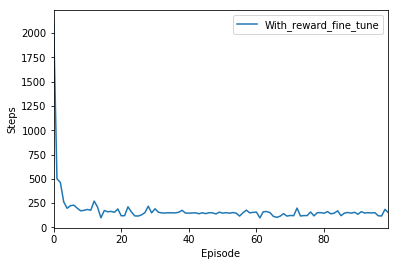

In [6]:
step_result.plot()
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.show()